# build obs_vista camera description

In this notebook we will build the files describing the VISTA camera geometry and properties. We are now using the gen 3 yaml format to describe the camera. 

https://github.com/lsst/obs_base/blob/master/python/lsst/obs/base/yamlCamera.py

For stacks the gain is effectively multiplied by the number of exposures (6). However there are complications due to clipping. We are currently working on replacing the per stack gain with a per exposure gain such that the gain must be multiplied by the exposure number when computing the variance later.

http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/vista-gain

In [2]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          22.0.1-3-g7ae64ea+5b0c808533 	current w_2021_43 w_latest setup
obs_vista             22.0.0-2   	current setup


## 1 Load camera data files
Originally we produced a fits file for each ccd based on the obs_subaru example. Now we are deprecating all gen 2 code and using the yaml camera description format only.

In [3]:
import yaml
import lsst
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.geom as geom
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle, AltAz, EarthLocation
from astropy.wcs import WCS
import astropy.units as u

import matplotlib.pyplot as plt

In [4]:
#Use an example stack to reverse engineer the camera geometry
ex_stack='/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00088_st.fit'
ex_stack2='/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00144_st.fit'
ex_stackZ='/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20120924/v20120924_00582_st.fit'
ex_fit='/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00088.fit'
gain = Table.read('./gain.csv')
readout_noise = Table.read('./readout_noise.csv')
saturation = Table.read('./saturation.csv')

In [5]:
gain #electrons/ADU

id,NB118,Z,Y,J,Average
int64,float64,float64,float64,float64,float64
1,3.648,3.628,3.63,3.717,3.66
2,4.28,4.251,4.206,4.247,4.25
3,3.957,3.947,3.858,4.045,3.95
4,4.154,4.102,4.041,4.335,4.16
5,4.16,4.139,4.125,4.517,4.24
6,4.063,4.074,4.11,4.179,4.11
7,3.882,3.78,3.787,3.903,3.84
8,4.153,4.216,4.176,4.326,4.22
9,4.639,4.5,4.396,4.589,4.53


In [6]:
readout_noise # ADU?

id,NB118,Z,Y,J
int64,float64,float64,float64,float64
1,22.903,22.782,22.791,27.231
2,22.394,26.694,22.007,26.665
3,20.708,24.783,20.186,25.402
4,21.734,25.758,21.145,27.222
5,21.77,25.989,21.586,28.364
6,21.258,25.579,21.504,26.241
7,24.378,23.737,19.814,24.505
8,21.732,26.474,21.853,27.16
9,19.418,18.838,18.401,19.209


In [7]:
saturation #ADU? non-linearity - percent

detector,saturation,non-linearity
int64,int64,float64
1,33000,2.2
2,32000,3.3
3,33000,3.8
4,32000,3.5
5,24000,2.0
6,26000,3.0
7,35000,2.0
8,33000,3.4
9,35000,3.3


## Camera geomtry
It is possible to set a given CCD world coordinate system using the camera geometry and the telescope tracking radec. We may therefore want to describe the camera geometry by taking an example exposure and taking the offset of the pixels from the reference radec in the centre of the focal plane. These will be different for stacks vs single exposures due to dithers changing the pixel bounding boxes. These will also differ depending on the dither patterns adopted by a given survey.

POINTING: 35.43265 -4.72313
1 (5406.375, 6832.391) (array(5405.375), array(6831.391)) (array(5398.81344965), array(6842.24391529)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.43192856, -4.72219667)> <SkyCoord (ICRS): (ra, dec) in deg
    (35.94007405, -4.0782962)>
2 (2482.837, 6845.058) (array(2481.837), array(6844.058)) (array(2474.15164877), array(6851.27979031)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.43182297, -4.7225415)> <SkyCoord (ICRS): (ra, dec) in deg
    (35.66564138, -4.07718605)>


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


3 (-431.6327, 6849.338) (array(-432.6327), array(6848.338)) (array(-439.55658627), array(6849.60932079)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.43189576, -4.72310527)> <SkyCoord (ICRS): (ra, dec) in deg
    (35.39002539, -4.07732451)>
4 (-3348.992, 6852.811) (array(-3349.992), array(6851.811)) (array(-3360.42619197), array(6849.52171247)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.43156255, -4.7234435)> <SkyCoord (ICRS): (ra, dec) in deg
    (35.11419777, -4.07834334)>
5 (5396.107, 2949.336) (array(5395.107), array(2948.336)) (array(5394.79674479), array(2957.09870851)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.43252443, -4.72239401)> <SkyCoord (ICRS): (ra, dec) in deg
    (35.94303911, -4.44316611)>
6 (2477.565, 2953.229) (array(2476.565), array(2952.229)) (array(2474.69163855), array(2956.14640333)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.43237619, -4.72285362)> <SkyCoord (ICRS): (ra, dec) in deg
    (35.66724337, -4.44292878)>
7 (-439.3481, 2957.282) (array(-440.3481), array

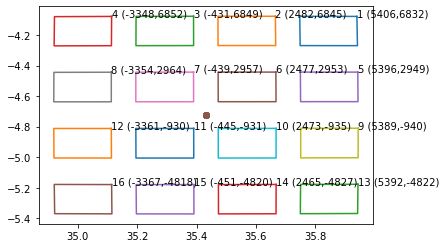

In [8]:
f=fits.open(ex_stack)
trackingRaDec=SkyCoord(f[0].header['RA'],f[0].header['DEC'],unit='deg')
print('POINTING:',f[0].header['RA'],f[0].header['DEC'])
for i in range(1,17):
    w=WCS(f[i].header)
    print(i,
        (f[i].header['CRPIX1'],f[i].header['CRPIX2']),
        w.world_to_pixel(SkyCoord(f[i].header['CRVAL1']*u.deg,f[i].header['CRVAL2']*u.deg)),
        w.world_to_pixel(trackingRaDec),
        w.pixel_to_world(f[i].header['CRPIX1'],f[i].header['CRPIX2']),
        w.pixel_to_world(0,0),
        
    )
    plt.scatter(w.pixel_to_world(f[i].header['CRPIX1'],f[i].header['CRPIX2']).ra.deg,
                w.pixel_to_world(f[i].header['CRPIX1'],f[i].header['CRPIX2']).dec.deg)
    plt.plot(
        [w.pixel_to_world(0,0).ra.deg,w.pixel_to_world(0,2048).ra.deg,
         w.pixel_to_world(2048,2048).ra.deg,w.pixel_to_world(2048,0).ra.deg,w.pixel_to_world(0,0).ra.deg],
        [w.pixel_to_world(0,0).dec.deg,w.pixel_to_world(0,2048).dec.deg,
         w.pixel_to_world(2048,2048).dec.deg,w.pixel_to_world(2048,0).dec.deg,w.pixel_to_world(0,0).dec.deg])
    plt.annotate(
        "{} ({},{})".format(i,int(f[i].header['CRPIX1']),int(f[i].header['CRPIX2'])),
        (w.pixel_to_world(0,0).ra.deg,w.pixel_to_world(0,0).dec.deg))


POINTING: 34.539904 -4.99293
1 (5417.118, 6859.286) (array(5416.118), array(6858.286)) (array(5410.62183946), array(6867.50608715)) <SkyCoord (ICRS): (ra, dec) in deg
    (34.54052435, -4.99370788)> <SkyCoord (ICRS): (ra, dec) in deg
    (34.03024523, -5.63945932)>
2 (2498.018, 6866.384) (array(2497.018), array(6865.384)) (array(2490.31345838), array(6871.84402728)) <SkyCoord (ICRS): (ra, dec) in deg
    (34.54063845, -4.99344681)> <SkyCoord (ICRS): (ra, dec) in deg
    (34.30543812, -5.64088347)>
3 (-420.2071, 6871.649) (array(-421.2071), array(6870.649)) (array(-427.15669958), array(6870.99631263)) <SkyCoord (ICRS): (ra, dec) in deg
    (34.54056587, -4.99286696)> <SkyCoord (ICRS): (ra, dec) in deg
    (34.58155607, -5.64077045)>
4 (-3337.845, 6873.688) (array(-3338.845), array(6872.688)) (array(-3349.09425913), array(6870.40329456)) <SkyCoord (ICRS): (ra, dec) in deg
    (34.54097424, -4.99261701)> <SkyCoord (ICRS): (ra, dec) in deg
    (34.85815525, -5.63953993)>
5 (5408.78, 2971.0

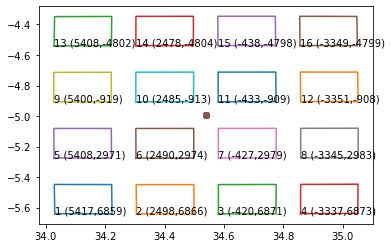

In [12]:
f=fits.open(ex_stackZ)
trackingRaDec=SkyCoord(f[0].header['RA'],f[0].header['DEC'],unit='deg')
print('POINTING:',f[0].header['RA'],f[0].header['DEC'])
for i in range(1,17):
    w=WCS(f[i].header)
    print(i,
        (f[i].header['CRPIX1'],f[i].header['CRPIX2']),
        w.world_to_pixel(SkyCoord(f[i].header['CRVAL1']*u.deg,f[i].header['CRVAL2']*u.deg)),
        w.world_to_pixel(trackingRaDec),
        w.pixel_to_world(f[i].header['CRPIX1'],f[i].header['CRPIX2']),
        w.pixel_to_world(0,0),
        
    )
    plt.scatter(w.pixel_to_world(f[i].header['CRPIX1'],f[i].header['CRPIX2']).ra.deg,
                w.pixel_to_world(f[i].header['CRPIX1'],f[i].header['CRPIX2']).dec.deg)
    plt.plot(
        [w.pixel_to_world(0,0).ra.deg,w.pixel_to_world(0,2048).ra.deg,
         w.pixel_to_world(2048,2048).ra.deg,w.pixel_to_world(2048,0).ra.deg,w.pixel_to_world(0,0).ra.deg],
        [w.pixel_to_world(0,0).dec.deg,w.pixel_to_world(0,2048).dec.deg,
         w.pixel_to_world(2048,2048).dec.deg,w.pixel_to_world(2048,0).dec.deg,w.pixel_to_world(0,0).dec.deg])
    plt.annotate(
        "{} ({},{})".format(i,int(f[i].header['CRPIX1']),int(f[i].header['CRPIX2'])),
        (w.pixel_to_world(0,0).ra.deg,w.pixel_to_world(0,0).dec.deg))

In [13]:
fits.open(ex_stack)[0].header["HIERARCH ESO TEL POSANG"],fits.open(ex_stackZ)[0].header["HIERARCH ESO TEL POSANG"]

(-90.008, 90.01)

In [10]:
f[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'ESO     '                    / European Southern Observatory         
DATE    = '2012-11-23T01:28:56'         / Date this file was written            
TELESCOP= 'VISTA   '                    / ESO Telescope Name                    
INSTRUME= 'VIRCAM  '                    / Instrument used.                      
OBJECT  = 'No name '           / Original target.                               
RA      =            35.432650          / 02:21:43.8 RA (J2000) pointing (deg)  
DEC     =             -4.723

In [11]:
f[1].header

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 2105 / length of original image axis                  
NAXIS2  =                 2127 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
EXTNAME = 'DET1.CHIP1'         / Extension name                                 
ORIGIN  = 'ESO     ' / European Southern Observatory                            
DATE    = '2012-11-23T01:30:10.4352' / Date the file was written                
EXPTIME =                  10. / Corrected to ndit = 1                          
MJD-OBS =       56254.06177820 / Obs start 2012-11-23T01:28:57.636              
DATE-OBS= '2012-11-23T01:28:

In [15]:
f=fits.open(ex_fit)
for i in range(1,17):
    print(i)
    w=WCS(f[i].header)
    print(
        #(f[i].header['CRVAL1']*u.deg,f[i].header['CRVAL2']*u.deg),
        w.world_to_pixel(SkyCoord(f[i].header['CRVAL1']*u.deg,f[i].header['CRVAL2']*u.deg))
    )

1
(array(5389.2), array(6842.))
2
(array(2470.8), array(6842.))
3
(array(-447.6), array(6842.))
4
(array(-3366.), array(6842.))
5
(array(5389.2), array(2950.8))
6
(array(2470.8), array(2950.8))
7
(array(-447.6), array(2950.8))
8


 [astropy.io.fits.verify]


(array(-3366.), array(2950.8))
9
(array(5389.2), array(-940.4))
10
(array(2470.8), array(-940.4))
11
(array(-447.6), array(-940.4))
12
(array(-3366.), array(-940.4))
13
(array(5389.2), array(-4831.6))
14
(array(2470.8), array(-4831.6))
15
(array(-447.6), array(-4831.6))
16
(array(-3366.), array(-4831.6))


## Gen 3 YAML file version

In gen 3 the camera is defined in a single yaml file. Since we are currently developing obs_vista to be compatible with both we here also make the yaml file. gen 2 will be deprecated fully at some point before LSST commences.

In [16]:
#plateScale = 16.95    # Calculated from 0.339 arcesc/px and px = 0.02 mm
#1.24 from necam example


In [26]:
ccdSize=2048 #2048 #This must be smaller than the actual image we should get the maximin
spacer=200

#Physical mm distances are never used. Everything is in terms of sky arcsec
pixelSize=0.02 # mm
plateScale= 0.336 # arcsec 
# Sets the plate scale in arcsec/mm:
pixelScale = plateScale/pixelSize #    # Calculated from 0.339 arcesc/px and px = 0.02 mm

f=fits.open(ex_stack)
trackingRaDec=SkyCoord(f[0].header['RA'],f[0].header['DEC'],unit='deg')


camera = {
    'name': 'vista',
    'plateScale':plateScale,
    'transforms': {
        'nativeSys': 'FocalPlane',
        'FieldAngle': {
            'transformType': 'radial', #'radial' or 'affine'
            'coeffs': [0.0, 1.0]
        }
    },
    'CCDs': {}
    
}

for i in range(16):
    h=f[i+1].header
    w=WCS(h)
    
    #ref_pos=w.world_to_pixel(SkyCoord(h['CRVAL1']*u.deg,h['CRVAL2']*u.deg))
    ref_pos=w.world_to_pixel(trackingRaDec)
    this_dict={
        'name': 'ccd{}'.format(i+1),
        'id': i+1,
        'serial': str(i+1),
        'detectorType': 0,
        'bbox': [[0,0], [ccdSize, ccdSize]], 
        'pixelSize': [1.,1.],#mm? pixels?
        'transformDict':{
            'nativeSys': 'Pixels',
            'transforms': 'None'
        },
        #This was set based on inspecting the results - ccdSize is removed and flipXY are set to get corners correct and up and down correct
        'refpos': [-h['CRPIX1']+ccdSize,-h['CRPIX2']+ccdSize],
        'offset': [0,0],
        'transposeDetector': False,
        'pitch': 0.0,
        'yaw': 0.0,
        'roll': 0.0,
        'amplifiers':{
            'AMP_E2V':{
                'rawBBox': [[0,0],[ccdSize, ccdSize]],
                'hdu': i+1 ,
                'ixy': [0,0],
                'perAmpData': True,
                'rawDataBBox': [[0,0],[ccdSize, ccdSize]],
                'rawSerialOverscanBBox': [[0,0],[0,0]],
                'rawParallelOverscanBBox': [[0,0],[0,0]],
                'rawSerialPrescanBBox': [[0,0],[0,0]],
                'readCorner': 'LL',
                'gain': float(gain[i]['Average'] * 7),
                'readNoise': float(
                    np.mean([
                        readout_noise[i]['Z'],
                        readout_noise[i]['Y'],
                        readout_noise[i]['J']
                    ])
                ),
                'saturation': int(saturation[i]['saturation']),
                'flipXY': [True, True],
                'linearityCoeffs': [
                    float(saturation[i]['non-linearity']/100), 
                    int(saturation[i]['saturation'])
                ],
                'linearityType': "None",
                'linearityThreshold': 0,
                'linearityMax': int(saturation[i]['saturation']),
            }
        }
    }
    camera['CCDs']['ccd{}'.format(i+1)]=this_dict
    
with open('vircam.yaml', 'w') as file:
    documents = yaml.dump(camera, file)

In [27]:
camera

{'name': 'vista',
 'plateScale': 0.336,
 'transforms': {'nativeSys': 'FocalPlane',
  'FieldAngle': {'transformType': 'radial', 'coeffs': [0.0, 1.0]}},
 'CCDs': {'ccd1': {'name': 'ccd1',
   'id': 1,
   'serial': '1',
   'detectorType': 0,
   'bbox': [[0, 0], [2048, 2048]],
   'pixelSize': [1.0, 1.0],
   'transformDict': {'nativeSys': 'Pixels', 'transforms': 'None'},
   'refpos': [-3358.375, -4784.391],
   'offset': [0, 0],
   'transposeDetector': False,
   'pitch': 0.0,
   'yaw': 0.0,
   'roll': 0.0,
   'amplifiers': {'AMP_E2V': {'rawBBox': [[0, 0], [2048, 2048]],
     'hdu': 1,
     'ixy': [0, 0],
     'perAmpData': True,
     'rawDataBBox': [[0, 0], [2048, 2048]],
     'rawSerialOverscanBBox': [[200, 200], [200, 200]],
     'rawParallelOverscanBBox': [[200, 200], [200, 200]],
     'rawSerialPrescanBBox': [[200, 200], [200, 200]],
     'readCorner': 'LL',
     'gain': 25.62,
     'readNoise': 24.268,
     'saturation': 33000,
     'flipXY': [True, True],
     'linearityCoeffs': [0.0220